In [ ]:
import pandas as pd
import networkx as nx
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from collections import Counter
from tqdm import tqdm
import numpy as np
import pandas as pd
import regex as re
import spacy

sample_dataset = "../datasets/sample_emails.csv"

In [2]:
# -----------------------------
# 1. Text Preprocessing Utilities
# -----------------------------

# def tokenize(text):

#     if not isinstance(text, str):
#         text = str(text)

#     word_pattern = r"""
#         \b(?:Mr|Mrs|Ms|Dr|Prof|Sr|Jr|St)\.    # Common abbreviations with a period
#         | \b\w+://[^\s]+                      # URLs
#         | [A-Za-z]+(?:'t|'ve|'d|'re|'ll|'m|n't)?  # Contractions
#         | \d+(?:\.\d+)?(?:[a-z]+)?            # Numbers and percentages
#         | [\w\-]+                             # Words with hyphens
#         | [^\w\s]+                            # Punctuation
#         """
#     tokenized_words =  re.findall(word_pattern, text, re.VERBOSE)

#     return tokenized_words

def tokenize(text):
    """Converts input to string, lowercases, and splits by whitespace."""
    if not isinstance(text, str):
        text = str(text)
    return text.lower().split()

def build_vocab(sentences, min_freq=1):
    """Build a vocabulary mapping from token to index."""
    counter = Counter()
    for sent in sentences:
        counter.update(tokenize(sent))
    # Reserve index 0 for padding and 1 for unknown tokens
    vocab = {word: i + 2 for i, (word, count) in enumerate(counter.items()) if count >= min_freq}
    vocab['<PAD>'] = 0
    vocab['<UNK>'] = 1
    return vocab

def text_to_indices(text, vocab):
    """Convert text string to a list of token indices."""
    tokens = tokenize(text)
    return [vocab.get(token, vocab['<UNK>']) for token in tokens]

In [3]:
# -----------------------------
# 2. Dataset Definition
# -----------------------------

class EmailHierarchyDataset(Dataset):
    """
    Dataset for emails with hierarchy labels.
    Assumes the CSV file has:
      - 'content': preprocessed email text (input)
      - 'hierarchy_label': the hierarchy label (output)
    """
    def __init__(self, csv_file=None, df=None, vocab=None, max_len=100):
        if csv_file is not None:
            self.data = pd.read_csv(csv_file)
        elif df is not None:
            self.data = df
        else:
            raise ValueError("Either csv_file or df must be provided")
            
        # Map the hierarchy_label to an integer index
        self.label_mapping = {
                'Sender higher': 0,
                'Similar level': 1,
                'Recipient higher': 2,
                # 'Unknown': 3
            }
        self.data['label'] = self.data['Hierarchy_Label'].map(self.label_mapping)
        
        # Inverse mapping for result interpretation
        self.idx_to_label = {idx: label for label, idx in self.label_mapping.items()}

        # Build vocabulary if not provided
        if vocab is None:
            self.vocab = build_vocab(self.data['content'].tolist())
        else:
            self.vocab = vocab

        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        text = row['content']
        label = row['label']
        indices = text_to_indices(text, self.vocab)
        # Pad or truncate the sequence to max_len
        if len(indices) < self.max_len:
            indices = indices + [self.vocab['<PAD>']] * (self.max_len - len(indices))
        else:
            indices = indices[:self.max_len]
        return torch.tensor(indices, dtype=torch.long), torch.tensor(label, dtype=torch.long)

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


# Hyper parameters
embedding_dim = 256
hidden_dim = 256
num_layers = 2
batch_size = 64
num_epochs = 10
learning_rate = 0.0002
max_len = 200
test_size = 0.2

# Load the dataset (ensure the CSV file is in your working directory)
full_dataset = EmailHierarchyDataset(sample_dataset, max_len=max_len)

# Split dataset into train and test sets
train_size = int((1 - test_size) * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Determine vocabulary size and number of classes from the dataset
vocab_size = len(full_dataset.vocab)
output_dim = len(full_dataset.label_mapping)

# Print dataset statistics
print(f"Total dataset size: {len(full_dataset)}")
print(f"Training set size: {len(train_dataset)}")
print(f"Test set size: {len(test_dataset)}")
print(f"Vocabulary size: {vocab_size}")
print(f"Number of classes: {output_dim}")

Using device: cuda
Total dataset size: 25000
Training set size: 20000
Test set size: 5000
Vocabulary size: 83649
Number of classes: 3


In [ ]:
from datasets import Dataset
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
from transformers import BertTokenizer
from transformers import BertForSequenceClassification
from transformers import TrainingArguments, Trainer

nlp = spacy.load("en_core_web_sm")

def anonymize_names(text):
    doc = nlp(text)
    replaced = text
    for ent in reversed(doc.ents):  # Reversed to avoid index shifting
        if ent.label_ == "PERSON":
            replaced = replaced[:ent.start_char] + "<NAME>" + replaced[ent.end_char:]
    return replaced

df = full_dataset.data

# make a dataset which contains only content and label

df = df[['content', 'label']]
df.loc[:, 'content'] = df['content'].astype(str)
df.loc[:, 'content'] = df['content'].apply(anonymize_names)
df.loc[:, 'label'] = df['label'].astype(int)
dataset = Dataset.from_pandas(df)

print('here')

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

def tokenize(exmaple):
    return tokenizer(exmaple["content"], padding="max_length", truncation=True, max_length=128)

tokenized_dataset = dataset.map(tokenize, batched = True)
tokenized_dataset = tokenized_dataset.train_test_split(test_size=0.2)

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)

training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    gradient_accumulation_steps=4,
    max_grad_norm=1.0,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_dir='./logs',
    fp16=False,
    no_cuda=False,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
)
trainer.train()
trainer.evaluate()
# Save the model
model.save_pretrained("./email_hierarchy_model")
tokenizer.save_pretrained("./email_hierarchy_model")

here


Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification
import torch
import torch.nn.functional as F
import pandas as pd
from tqdm import tqdm

# Load model and tokenizer from saved directory
model_path = "../email_hierarchy_model"
tokenizer = BertTokenizer.from_pretrained(model_path)
model = BertForSequenceClassification.from_pretrained(model_path)

# Set model to evaluation mode and move to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

idx_to_label = {
    0: "Sender higher",
    1: "Similar level",
    2: "Recipient higher"
}

def predict_label(text):
    # Tokenize input text
    inputs = tokenizer(text, return_tensors="pt", padding="max_length", truncation=True, max_length=128)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Run the model
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        probabilities = F.softmax(logits, dim=1)
        predicted_class = torch.argmax(probabilities, dim=1).item()
        confidence = probabilities[0][predicted_class].item()

    return idx_to_label[predicted_class], confidence

# Test the model with test data
test_data_path = "../datasets/genz_emails_final_translated.csv"
test_df = pd.read_csv(test_data_path)

print(test_df.head())


                                            original   
0  Hello ,\n\nI need a computer and flat screen m...  \
1  Please disregard to prior version and use this...   
2  \n\t [IMAGE] \t\n\tThanksgiving is just around...   
3  The PRELIMINARY Violation Memos for 11/16/01 h...   
4  Start Date: 3/30/01; HourAhead hour: 24;  No a...   

                                           generated     id   Hierarchy_Label  
0  the location is EB3240E. ONLY- one computer an...   6868     Sender higher  
1  slap the previous version and use this one, no...  24016     Sender higher  
2  [IMAGE] Thanksgiving is just around the corner...   9668  Recipient higher  
3  the PRELIMINARY Violation Memos for 11/16/01 h...  13640  Recipient higher  
4  no variances detected. LOG MESSAGES: PARSING F...  14018     Similar level  


100%|██████████| 2503/2503 [01:07<00:00, 36.92it/s]


Accuracy: 93.21%
Classification Report:
                  precision    recall  f1-score   support

Recipient higher     0.9328    0.9121    0.9224      1081
   Sender higher     0.9272    0.9464    0.9367      1306
   Similar level     0.9823    0.9569    0.9694       116

        accuracy                         0.9321      2503
       macro avg     0.9475    0.9385    0.9428      2503
    weighted avg     0.9322    0.9321    0.9320      2503


Confusion Matrix:
[[ 986   93    2]
 [  70 1236    0]
 [   1    4  111]]
Confusion matrix saved as 'confusion_matrix.png'


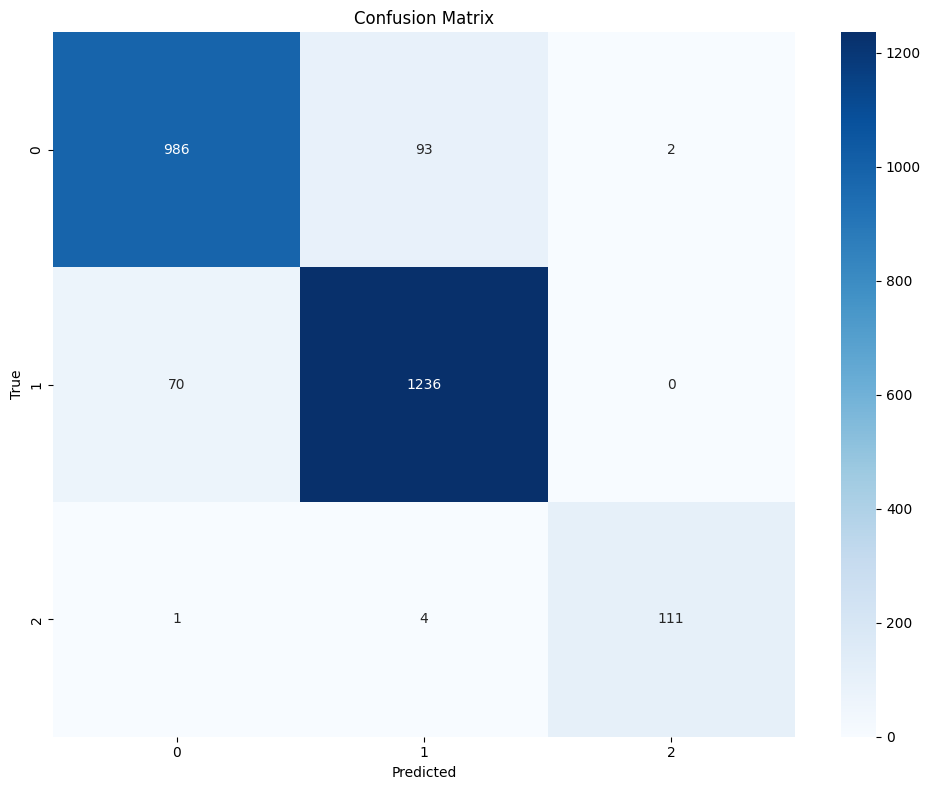

In [14]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

test_df = test_df[['original', 'Hierarchy_Label']]
test_df.loc[:, 'original'] = test_df['original'].astype(str)
test_df.loc[:, 'Hierarchy_Label'] = test_df['Hierarchy_Label'].astype(str)

true_labels = []
predicted_labels = []
confidences = []
texts = []

for index, row in tqdm(test_df.iterrows(), total=test_df.shape[0]):
    text = row['original']
    true_label = row['Hierarchy_Label']
    predicted_label, confidence = predict_label(text)

    texts.append(text)
    true_labels.append(true_label)
    predicted_labels.append(predicted_label)
    confidences.append(confidence)

accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Accuracy: {accuracy * 100:.2f}%")

print("Classification Report:")
print(classification_report(true_labels, predicted_labels, digits=4))

# Optional: Confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print("\nConfusion Matrix:")
print(conf_matrix)

# Store results if needed
results_df = pd.DataFrame({
    'Text': texts,
    'True_Label': true_labels,
    'Predicted_Label': predicted_labels,
    'Confidence': confidences
})

cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig('confusion_matrix.png')
print("Confusion matrix saved as 'confusion_matrix.png'")

  0%|          | 0/2503 [00:00<?, ?it/s]

100%|██████████| 2503/2503 [03:03<00:00, 13.65it/s]


Accuracy: 85.30%
Classification Report:
                  precision    recall  f1-score   support

Recipient higher     0.8571    0.7993    0.8272      1081
   Sender higher     0.8401    0.8974    0.8678      1306
   Similar level     0.9900    0.8534    0.9167       116

        accuracy                         0.8530      2503
       macro avg     0.8958    0.8500    0.8706      2503
    weighted avg     0.8544    0.8530    0.8525      2503


Confusion Matrix:
[[ 864  216    1]
 [ 134 1172    0]
 [  10    7   99]]
Confusion matrix saved as 'confusion_matrix.png'


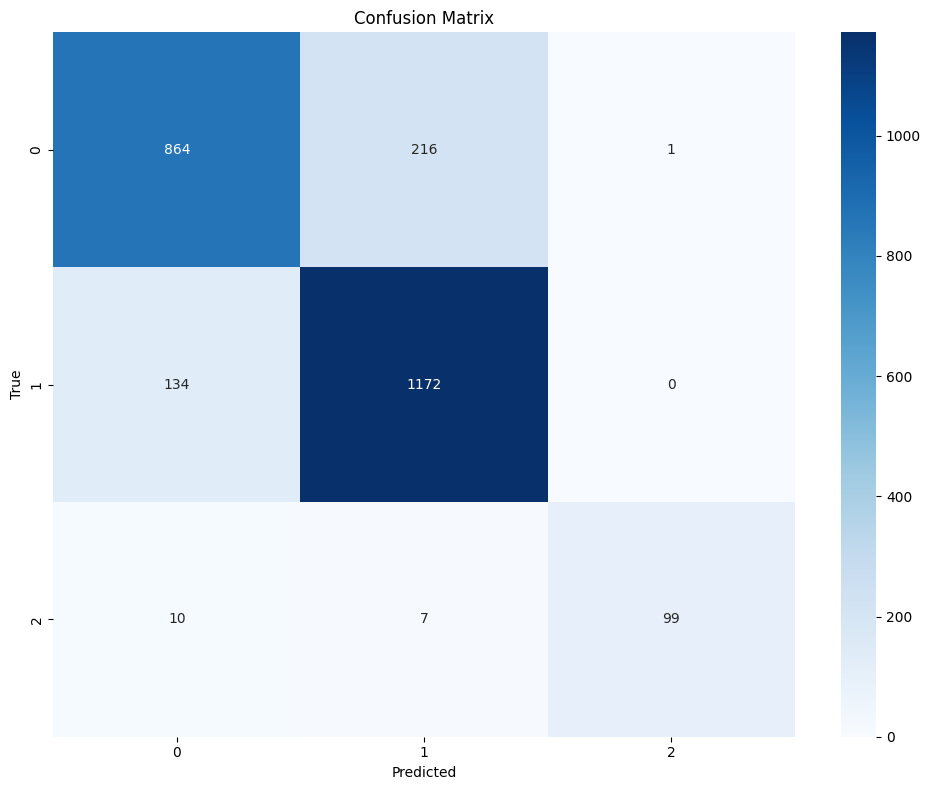

In [16]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

test_df = test_df[['generated', 'Hierarchy_Label']]
test_df.loc[:, 'generated'] = test_df['generated'].astype(str)
test_df.loc[:, 'Hierarchy_Label'] = test_df['Hierarchy_Label'].astype(str)

true_labels = []
predicted_labels = []
confidences = []
texts = []

for index, row in tqdm(test_df.iterrows(), total=test_df.shape[0]):
    text = row['generated']
    true_label = row['Hierarchy_Label']
    predicted_label, confidence = predict_label(text)

    texts.append(text)
    true_labels.append(true_label)
    predicted_labels.append(predicted_label)
    confidences.append(confidence)

accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Accuracy: {accuracy * 100:.2f}%")

print("Classification Report:")
print(classification_report(true_labels, predicted_labels, digits=4))

# Optional: Confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print("\nConfusion Matrix:")
print(conf_matrix)

# Store results if needed
results_df = pd.DataFrame({
    'Text': texts,
    'True_Label': true_labels,
    'Predicted_Label': predicted_labels,
    'Confidence': confidences
})

cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig('genz_confusion_matrix.png')
print("Confusion matrix saved as 'confusion_matrix.png'")

In [3]:
# write code that will find the index of the datapoint which predicts the normal label correctly but genz wrongly


test_df = test_df[['original', 'generated', 'Hierarchy_Label', 'id']]
test_df.loc[:, 'original'] = test_df['original'].astype(str)
test_df.loc[:, 'generated'] = test_df['generated'].astype(str)
test_df.loc[:, 'Hierarchy_Label'] = test_df['Hierarchy_Label'].astype(str)
test_df.loc[:, 'id'] = test_df['id'].astype(int)

listA = []
listB = []

for index, row in tqdm(test_df.iterrows(), total=test_df.shape[0]):
    normal = row['original']
    genz = row['generated']
    true_label = row['Hierarchy_Label']

    predicted_label, confidence = predict_label(normal)
    predicted_genz_label, confidence = predict_label(genz)
    if predicted_label == true_label and predicted_genz_label != true_label:
        listA.append(row['id'])

    if predicted_genz_label == true_label and predicted_label != true_label:
        listB.append(row['id'])


print(listA[:5])
print(listB[:5])


  0%|          | 0/2503 [00:00<?, ?it/s]

100%|██████████| 2503/2503 [01:45<00:00, 23.66it/s]

[21135, 14337, 22163, 3848, 18353]
[2905, 4744, 13620, 7516, 12281]


In [2]:
from lime.lime_text import LimeTextExplainer
import numpy as np

test_original_df = test_df[['original', 'Hierarchy_Label']]
test_original_df.loc[:, 'original'] = test_original_df['original'].astype(str)
test_original_df.loc[:, 'Hierarchy_Label'] = test_original_df['Hierarchy_Label'].astype(str)

test_generated_df = test_df[['generated', 'Hierarchy_Label']]
test_generated_df.loc[:, 'generated'] = test_generated_df['generated'].astype(str)
test_generated_df.loc[:, 'Hierarchy_Label'] = test_generated_df['Hierarchy_Label'].astype(str)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

explainer = LimeTextExplainer(class_names=['Sender higher', 'Similar level', 'Recipient higher'])

def predict_proba(texts):
    inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True, max_length=128)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
    return torch.softmax(outputs.logits, dim=1).cpu().detach().numpy()

# Explain one example
explanation1 = explainer.explain_instance(
    text_instance="test_original_df['original'][0]",
    classifier_fn=predict_proba,
    num_features=10
)

# Show explanation
explanation1.show_in_notebook()

# Save the explanation to a file
explanation1.save_to_file("lime_explanation_original.html")


# Explain another example
explanation2 = explainer.explain_instance(
    text_instance="test_generated_df['generated'][0]",
    classifier_fn=predict_proba,
    num_features=10
)
# Show explanation
explanation2.show_in_notebook()
# Save the explanation to a file
explanation2.save_to_file("lime_explanation_generated.html")


Using device: cuda


OutOfMemoryError: CUDA out of memory. Tried to allocate 938.00 MiB. GPU 